# Imports

In [145]:



import copy
import tensorflow as tf
import random
import time
import numpy as np
from keras.datasets import mnist
import sys
import os
import itertools
import sklearn.cluster
import scipy.misc
from time import time 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.optimizers import adam_v2
from keras.losses import categorical_crossentropy
from tensorflow.keras.models import load_model
from tensorflow.python.client import device_lib



# Create and train a model

In [159]:
#ResNet implementation
def create_and_train_model(filters=64, s1=5, s2=5, s3=3,
               d1=0, d2=0, fc=256,
               lr=1e-3, decay=1e-3):
      (x_train, y_train), (x_test, y_test) = mnist.load_data()

      img_rows = img_cols = 28
      x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
      x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

      x_train = x_train.astype('float32')
      x_test = x_test.astype('float32')
      x_train /= 255
      x_test /= 255

      model = Sequential()
      model.add(Conv2D(filters, kernel_size=(s1, s1),
                        activation='relu',
                        input_shape=(28, 28, 1)))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Conv2D(filters*2, (s2, s2), activation='relu'))
      model.add(BatchNormalization())
      model.add(Conv2D(filters*2, (s3, s3), activation='relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Dropout(d1))
      model.add(Flatten())
      model.add(Dense(fc, activation='relu'))
      model.add(Dropout(d2))
      model.add(Dense(10))
      
      # print("SUMMARY OF MODEL")
      # model.summary()
      model.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

      final = Sequential()
      final.add(model)
      final.add(Activation('softmax'))
      final.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
      

      begin = time()
      history=final.fit(x_train,to_categorical(y_train, 10),
                  batch_size=512,
                  epochs=5,
                  shuffle=True,
                  verbose=2,
                  )
      # plt.plot(history.history['accuracy'])
      # plt.xlabel('Epoch')
      # plt.ylabel('Accuracy')
      # print('Training time:',time()-begin)
      
      return final
    

final=create_and_train_model()
final.save("model_from_paper")







Epoch 1/5
118/118 - 3s - loss: 0.1718 - accuracy: 0.9505 - 3s/epoch - 24ms/step
Epoch 2/5
118/118 - 2s - loss: 0.0369 - accuracy: 0.9887 - 2s/epoch - 17ms/step
Epoch 3/5
118/118 - 2s - loss: 0.0212 - accuracy: 0.9937 - 2s/epoch - 17ms/step
Epoch 4/5
118/118 - 2s - loss: 0.0178 - accuracy: 0.9942 - 2s/epoch - 17ms/step
Epoch 5/5
118/118 - 2s - loss: 0.0133 - accuracy: 0.9959 - 2s/epoch - 17ms/step


# Define variables

In [186]:
perturbation_count_test=10000 # max=10000
perturbation_count_train=10000 # max=60000
perturbation_count_test_arr=[100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250]
# perturbation_count_train_arr=[0,1000,1500,2000,2500,3000,3500]
perturbation_count_train_arr=[]
i=0
while i<10000:
    perturbation_count_train_arr.append(i)
    i+=200
# perturbation_count_train_arr=[0,100,200,300,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000,2400,2800,3200,3600,4000,4500,5000,5500,6000,7000,8000,9000,10000]
epsilon=0.2

# assert len(perturbation_count_test_arr)==len(perturbation_count_train_arr)

# Generate perturbation-based adversarial examples on test images (LinfPGD, perturbation_count_test)
Saved under npy/adversarial_examples_to_test_LinfPGD

In [162]:
from tensorflow.keras.models import load_model
import foolbox as fb
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

print("Tensorflow version: ",tf.__version__)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)


x_test = x_test.astype('float32')
x_test /= 255

model=load_model("model_from_paper")




#assign model to foolbox
fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))


# converting test data to type tensor
x_attack_to_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
x_attack_to_test=x_attack_to_test[:,:,:,np.newaxis]
y_attack_to_test=tf.convert_to_tensor(y_test, dtype=tf.int32)


attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack()

#Adversarial examples to test...
_,advs_to_test, success=attack(fmodel, x_attack_to_test[0:perturbation_count_test], y_attack_to_test[0:perturbation_count_test], epsilons=epsilon)

print(np.shape(advs_to_test))

np.save("npy/adversarial_examples_to_test_LinfPGD", advs_to_test)





Tensorflow version:  2.7.0
(10000, 28, 28, 1, 1)


# Generate perturbation-based adversarial examples on train images (LinfPGD, perturbation_count_train)
Saved under npy/adversarial_examples_to_train_LinfPGD

In [187]:
from tensorflow.keras.models import load_model
import foolbox as fb
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

tf.config.list_physical_devices('GPU')
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)


x_train = x_train.astype('float32')

x_train /= 255


model=load_model("model_from_paper")




#assign model to foolbox
fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))



#converting training data to type tensor
x_attack_to_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_attack_to_train=x_attack_to_train[:,:,:,np.newaxis]
y_attack_to_train=tf.convert_to_tensor(y_train, dtype=tf.int32)
attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack()

#Generate perturbation-based adversarial examples to train...
_,advs, success=attack(fmodel, x_attack_to_train[0:perturbation_count_train], y_attack_to_train[0:perturbation_count_train], epsilons=epsilon)
# _,advs1, success=attack(fmodel, x_attack_to_train[number_of_attacks_to_train:number_of_attacks_to_train*2], y_attack_to_train[number_of_attacks_to_train:number_of_attacks_to_train*2], epsilons=epsilon)      
# _,advs2, success=attack(fmodel, x_attack_to_train[number_of_attacks_to_train*2:number_of_attacks_to_train*3], y_attack_to_train[number_of_attacks_to_train*2:number_of_attacks_to_train*3], epsilons=epsilon)      
# _,advs3, success=attack(fmodel, x_attack_to_train[number_of_attacks_to_train*3:number_of_attacks_to_train*4], y_attack_to_train[number_of_attacks_to_train*3:number_of_attacks_to_train*4], epsilons=epsilon)    
# _,advs4, success=attack(fmodel, x_attack_to_train[number_of_attacks_to_train*4:number_of_attacks_to_train*5], y_attack_to_train[number_of_attacks_to_train*4:number_of_attacks_to_train*5], epsilons=epsilon)    
# advs_to_train=tf.concat([advs,advs1, advs2, advs3, advs4],0)
# print(np.shape(advs_to_train))
advs_to_train=advs


np.save("npy/adversarial_examples_to_train_LinfPGD", advs_to_train)

# Attack Model from Paper and Retrain with adversarial examples

4/4 [==============================] - 0s 64ms/step - loss: 0.0206 - accuracy: 0.9900
Test accuracy on clean testing data 0.9900000095367432
4/4 [==============================] - 0s 4ms/step - loss: 6.8124 - accuracy: 0.1400
Test accuracy on  100  perturbation-based adversarial examples: 0.14000000059604645
retraining model...
Epoch 1/5
1/1 - 1s - loss: 7.4408 - accuracy: 0.1350 - 512ms/epoch - 512ms/step
Epoch 2/5
1/1 - 0s - loss: 1.8155 - accuracy: 0.6750 - 166ms/epoch - 166ms/step
Epoch 3/5
1/1 - 0s - loss: 0.7800 - accuracy: 0.8450 - 10ms/epoch - 10ms/step
Epoch 4/5
1/1 - 0s - loss: 0.4133 - accuracy: 0.9100 - 12ms/epoch - 12ms/step
Epoch 5/5
1/1 - 0s - loss: 0.2526 - accuracy: 0.9450 - 12ms/epoch - 12ms/step
Retrained model with  200  perturbation-based adversarial examples
4/4 [==============================] - 0s 3ms/step - loss: 1.0149 - accuracy: 0.8100
Test accuracy on clean testing data 0.8100000023841858
4/4 [==============================] - 0s 4ms/step - loss: 2.0009 - a

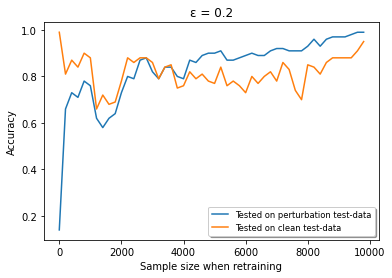

ADVERSARIAL IMAGES


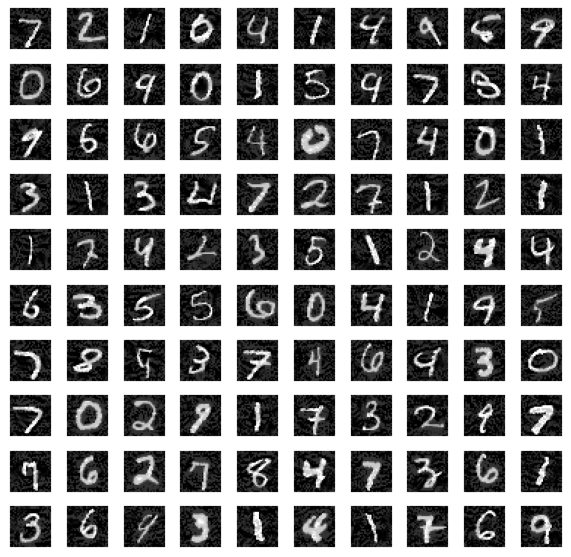

10000


AssertionError: 

In [183]:

from tensorflow.keras.models import load_model
import foolbox as fb
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


advs_to_test=np.load("npy/adversarial_examples_to_test_LinfPGD.npy")
advs_to_retrain=np.load("npy/adversarial_examples_to_train_LinfPGD.npy")
model=load_model("model_from_paper")




(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)


x_test = x_test.astype('float32')
x_test /= 255


#one-hot-encode y_test to test model
y_test=to_categorical(y_test)



def test_model(model_to_test,number_of_attacks_to_test):
    #test with original test data
    #TODO find out more parameters additionally to the accuracy to analyze
    acc = model_to_test.evaluate(x_test, y_test)
    print('Test accuracy on clean testing data:', acc[1])

    #test with adversarial data
    acc = model_to_test.evaluate(advs_to_test[0:number_of_attacks_to_test], y_test[0:number_of_attacks_to_test]
                                )
    print('Test accuracy on perturbation-based adversarial examples:', acc[1])
    return acc[1]








# Check if the sample size of the testing data makes a difference on accuracy
# results=[]
# for i in range(len(perturbation_count_test_arr)):
#     acc = model.evaluate(advs_to_test[0:perturbation_count_test_arr[i]], y_test[0:perturbation_count_test_arr[i]])
#     print('Test accuracy on ',perturbation_count_test_arr[i],' perturbation-based adversarial examples:', acc[1])
#     results.append(acc[1])

# print("History of accuracy on different test sample sized")
# plt.plot(perturbation_count_test_arr,results)
# plt.xlabel('Sample size')
# plt.ylabel('Accuracy')














#Retrain Models and evaluate if the number of examples to retrain makes a difference on the clean accuracy and the accuracy against perturbation
results_clean=[]
results_perturbation=[]
acc = model.evaluate(x_test[0:perturbation_count_test_arr[0]], y_test[0:perturbation_count_test_arr[0]])
results_clean.append(acc[1])
print('Test accuracy on clean testing data', acc[1])
acc = model.evaluate(advs_to_test[0:perturbation_count_test_arr[0]], y_test[0:perturbation_count_test_arr[0]])
print('Test accuracy on ',perturbation_count_test_arr[0],' perturbation-based adversarial examples:', acc[1])
results_perturbation.append(acc[1])


for i in range(len(perturbation_count_train_arr)):
    if i>0:

        #get saved model
        model1=load_model("model_from_paper")
    
        #retrain model with perturbation-based adversarial examples

        print("retraining model...")
        model1.fit(advs_to_retrain[0:perturbation_count_train_arr[i]],to_categorical(y_train[0:perturbation_count_train_arr[i]]),
            batch_size=512,
            epochs=5,
            shuffle=True,
            verbose=2,)
        print("Retrained model with ",perturbation_count_train_arr[i], " perturbation-based adversarial examples")
        # Test model against perturbation-based adversarial examples. Use fixed sample size on testing...
        acc = model1.evaluate(x_test[0:perturbation_count_test_arr[0]], y_test[0:perturbation_count_test_arr[0]])
        results_clean.append(acc[1])
        print('Test accuracy on clean testing data', acc[1])
        acc = model1.evaluate(advs_to_test[0:perturbation_count_test_arr[0]], y_test[0:perturbation_count_test_arr[0]])
        print('Test accuracy on ',perturbation_count_test_arr[0],' perturbation-based adversarial examples:', acc[1])
        results_perturbation.append(acc[1])


#plot results
fig, ax = plt.subplots()
ax.plot(perturbation_count_train_arr,results_perturbation, label='Tested on perturbation test-data')
ax.plot(perturbation_count_train_arr,results_clean, label='Tested on clean test-data')

legend = ax.legend(loc='lower right', shadow=True, fontsize='small')
plt.xlabel('Sample size when retraining')
plt.ylabel('Accuracy')
plt.title("ε = {}".format(epsilon))
plt.show()





#plot adversarial images
print("ADVERSARIAL IMAGES")
_, ax = plt.subplots(10, 10, figsize=(10, 10))

for i in range(100):
    temp = np.ones((32, 32, 3), dtype=np.float32)
    x=advs_to_test[i]
    x=x[:,:,0,0]
    temp[2:-2, 2:-2, 0] = x
    temp[2:-2, 2:-2, 1] = x
    temp[2:-2, 2:-2, 2] = x
    ax[i//10, i%10].imshow(temp)
    ax[i//10, i%10].axis('off')

plt.show()




# _, ax = plt.subplots(1, 2, figsize=(10, 10))

# temp = np.ones((32, 32, 3), dtype=np.float32)
# x=x_test[0]
# x=x[:,:,0]
# temp[2:-2, 2:-2, 0] = x
# temp[2:-2, 2:-2, 1] = x
# temp[2:-2, 2:-2, 2] = x
# ax[0].imshow(temp)
# ax[0].axis('off')

# temp = np.ones((32, 32, 3), dtype=np.float32)
# x=advs_to_test[0]
# x=x[:,:,0,0]
# temp[2:-2, 2:-2, 0] = x
# temp[2:-2, 2:-2, 1] = x
# temp[2:-2, 2:-2, 2] = x
# ax[1].imshow(temp)
# ax[1].axis('off')

# plt.show()

# print("ORIGINAL IMAGES")
# _, ax = plt.subplots(10, 10, figsize=(10, 10))
# for i in range(100):
#     temp = np.ones((32, 32, 3), dtype=np.float32)
#     x=x_test[i]
#     x=x[:,:,0]
#     temp[2:-2, 2:-2, 0] = x
#     temp[2:-2, 2:-2, 1] = x
#     temp[2:-2, 2:-2, 2] = x
#     ax[i//10, i%10].imshow(temp)
#     ax[i//10, i%10].axis('off')

# plt.show()


#RETRAIN MODEL WITH ADVERSARIAL EXAMPLES...

# print(len(advs_to_retrain))


# assert len(advs_to_retrain)>=perturbation_count_train and perturbation_count_train>0
# print("Retraining with {} Adversarial Examples...".format(perturbation_count_train))
# #retraining with adversarial images
# model.fit(advs_to_retrain[0:perturbation_count_train],to_categorical(y_train[0:perturbation_count_train]),
#             batch_size=512,
#             epochs=10,
#             shuffle=True,
#             verbose=2,)
# test_model(model,number_of_attacks_to_test=perturbation_count_test)


# Testing invariance based adversarial examples from paper (100 labels from 40 human participants)


INVARIANCE BASED ADVERSARIAL IMAGES


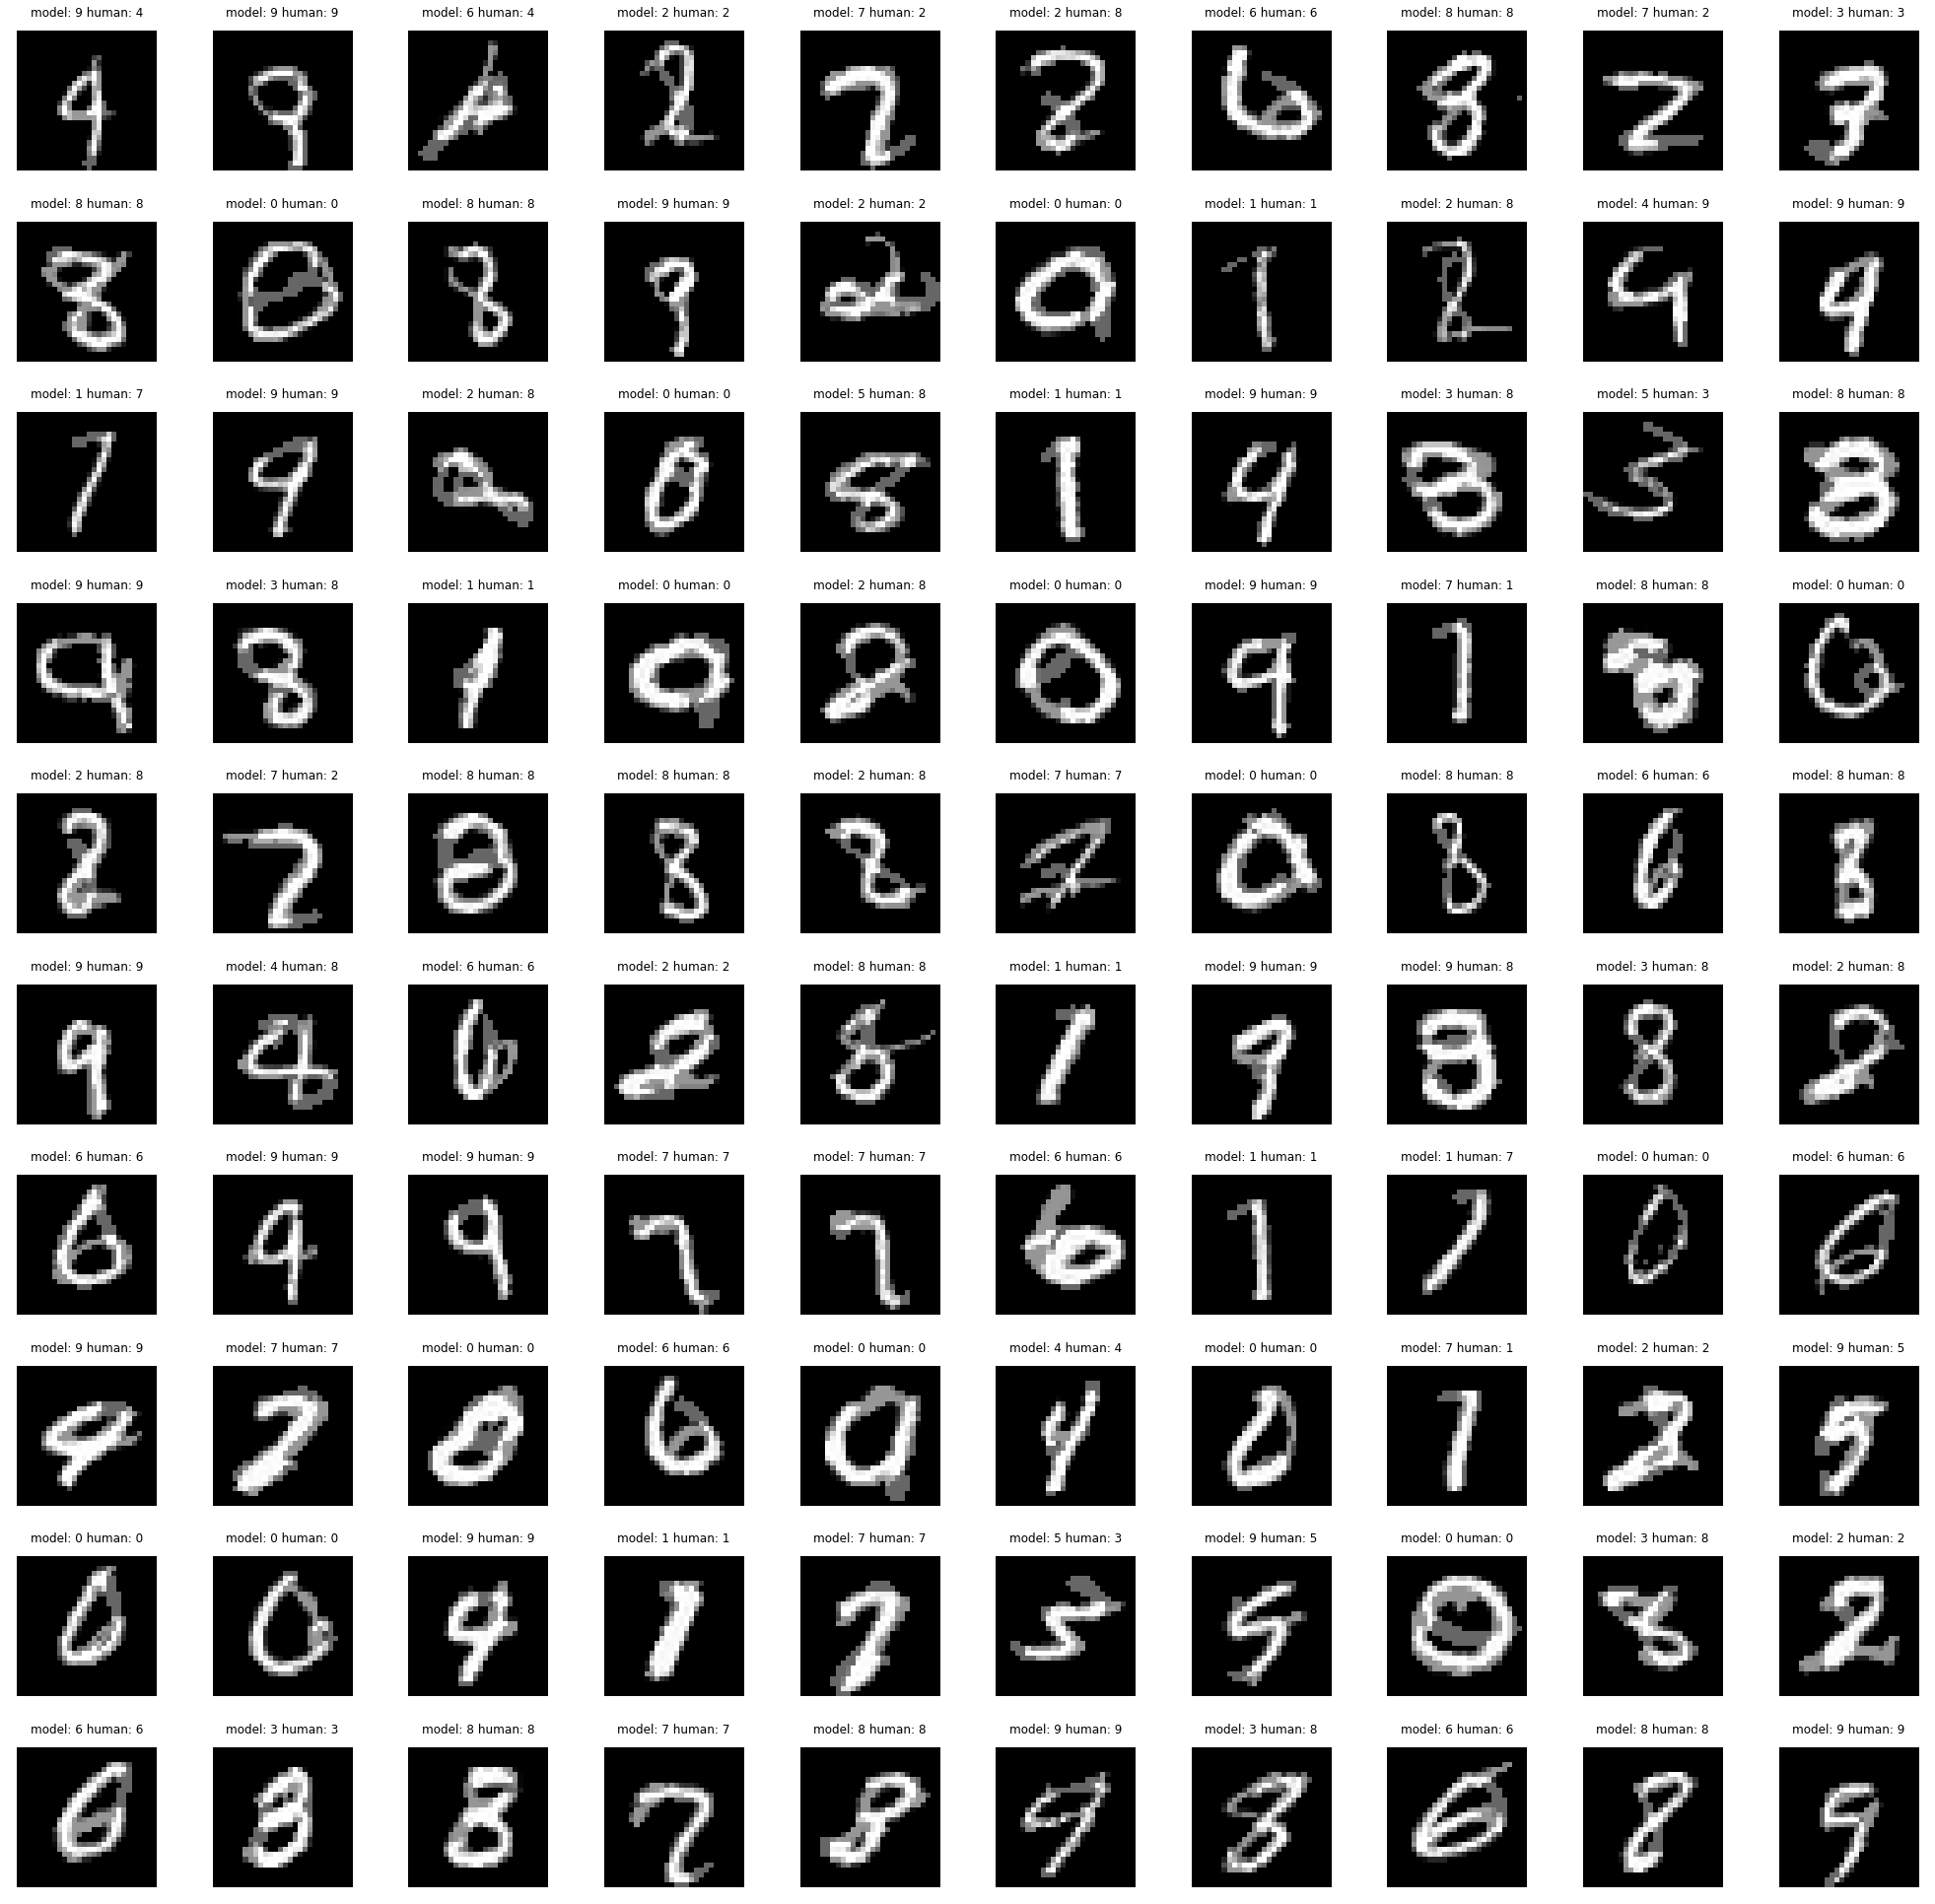

Human disagreeing: 28.999999999999996%


In [20]:
#Get model untrained with adversarial examples...
model=load_model("model_from_paper")


#get invariance-based adversarial examples generated from tramer et al.
adv_03 = np.load('invariance_examples/linf/automated_eps04.npy').astype(np.float32) / 255.
#get the human labels from tramer et.al
labels_h_03 = np.load('invariance_examples/linf/automated_eps04_labels.npy')

labels_h_03=to_categorical(labels_h_03)




print("INVARIANCE BASED ADVERSARIAL IMAGES")
disagreeing_human=0

#let my model predict with the invariance-based adversarial examples
predictions=model.predict(adv_03)
_, ax = plt.subplots(10, 10, figsize=(35, 35))
for i in range(100):
    temp = np.ones((32, 32, 3), dtype=np.float32)
    x=adv_03[i]
    # x=x[:,:,0]
    human_labeled=np.argmax(labels_h_03[i])
    temp[2:-2, 2:-2, 0] = x
    temp[2:-2, 2:-2, 1] = x
    temp[2:-2, 2:-2, 2] = x
    ax[i//10, i%10].imshow(temp)
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title("model: {} human: {}".format(np.argmax(predictions[i]), human_labeled))
    #check if human prediction differs from model prediction
    if human_labeled!=np.argmax(predictions[i]):
        disagreeing_human+=1

plt.show()

print("Human disagreeing: {}%".format(disagreeing_human/100*100))



# Save random 200 indices in file...
Needed to generate invariance based adversarial examples

In [7]:
rand_indices = np.random.randint(0,9999,(200))
np.save("npy/random_indices200", rand_indices)





# Find nearest Neighbours (Takes a lot of computation)

In [8]:
from keras.datasets import mnist
import numpy as np
from sklearn.neighbors import NearestNeighbors
from itertools import product
from scipy.ndimage.interpolation import rotate, shift

#  Load the MNIST data. 100 randomly chosen test points
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
idxs = np.load("npy/random_indices200.npy")
assert len(idxs) == 200
test_xs = X_test[idxs]
test_ys = Y_test[idxs]

# build a nearest neighbors classifier per class
N = 1
all_NNs = []

for i in range(10):
    #Reshape to 1D (28*28=784)
    X = X_train[Y_train == i].reshape(-1, 784)
    print("X: ", np.shape(X))
    nn = NearestNeighbors(n_neighbors=N)
   
    nn.fit(X)
    all_NNs.append(nn)
print(all_NNs)



# Rotation-translation parameters
limits = [3, 3, 30]
granularity = [5, 5, 31]
grid = list(product(*list(np.linspace(-l, l, num=g) for l, g in zip(limits, granularity))))

# tries all rotation-translations of the input and returns the closest neighbor from each class
def get_best_neighbors(x, y):
    xs = [shift(rotate(x, r, reshape=False), (tx, ty)).reshape(784) for (tx, ty, r) in grid]
    xs = np.asarray(xs.copy())
    
    nns = []
    y_nns = []
    grids_nn = []
    
    # find a nearest neighbor in each class
    for i in range(10):
        if i != y:
            X = X_train[Y_train == i]
            Y = Y_train[Y_train == i]
            distances, indices = all_NNs[i].kneighbors(xs, n_neighbors=1)

            best = np.argmin(np.reshape(distances, -1))
            best_idx = np.reshape(indices, -1)[best]
            nns.append(X[best_idx])
            y_nns.append(Y[best_idx])
            
            # store the inverse rotation+translation to be applied to the target
            grids_nn.append(-np.asarray(grid[best]))
    
    return nns, y_nns, grids_nn


all_nns = []
all_y_nns = []
all_grids_nns = []

# find nearest neighbors for some test inputs (this takes a little while)
for i in range(len(idxs)):
    if i % 10 == 0:
        print("{}/{} done".format(i, len(idxs)))
    x = test_xs[i]
    y = test_ys[i]

    # find the nearest neighbors for each class, with the corresponding rotation and translation
    nns, y_nns, grids_nns = get_best_neighbors(x, y)
    nn_advs = [shift(rotate(nn, r, reshape=False), (tx, ty)) for (nn, (tx, ty, r)) in zip(nns, grids_nns)]
    all_nns.append(nn_advs)
    all_y_nns.append(y_nns)
    all_grids_nns.append(np.asarray(grids_nns))

X:  (5923, 784)
X:  (6742, 784)
X:  (5958, 784)
X:  (6131, 784)
X:  (5842, 784)
X:  (5421, 784)
X:  (5918, 784)
X:  (6265, 784)
X:  (5851, 784)
X:  (5949, 784)
[NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1)]
0/200 done
10/200 done
20/200 done
30/200 done
40/200 done
50/200 done
60/200 done
70/200 done
80/200 done
90/200 done
100/200 done
110/200 done
120/200 done
130/200 done
140/200 done
150/200 done
160/200 done
170/200 done
180/200 done
190/200 done


# Save nearest Neighbours

In [9]:
# save everything!
np.save("X_test_200.npy", test_xs)
np.save("all_nns.npy", np.asarray(all_nns))
np.save("all_y_nns.npy", np.asarray(all_y_nns))
np.save("all_grids_nns.npy", np.asarray(all_grids_nns))

print(np.shape(test_xs))

(200, 28, 28)


In [10]:
def linf_attack(x, nn_adv, eps=0.3):
    x_adv = x.copy().astype(np.float32)
    nn_adv = nn_adv.astype(np.float32)
    
    # if possible, change the pixels to the target value
    idx = np.where((np.abs(nn_adv - x) <= eps*255.) & (x > 0))
    x_adv[idx] = nn_adv[idx]
    
    # otherwise, go as close as possible
    idx = np.where(np.abs(nn_adv - x) > eps*255.)
    sign = np.sign(nn_adv - x)
    x_adv[idx] += sign[idx] * eps * 255.
    
    x_adv = np.clip(x_adv, x.astype(np.float32) - eps*255, x.astype(np.float32) + eps*255)
    x_adv = np.clip(x_adv, 0, 255.)
    
    return x_adv

# Generate invariance based adversarial examples

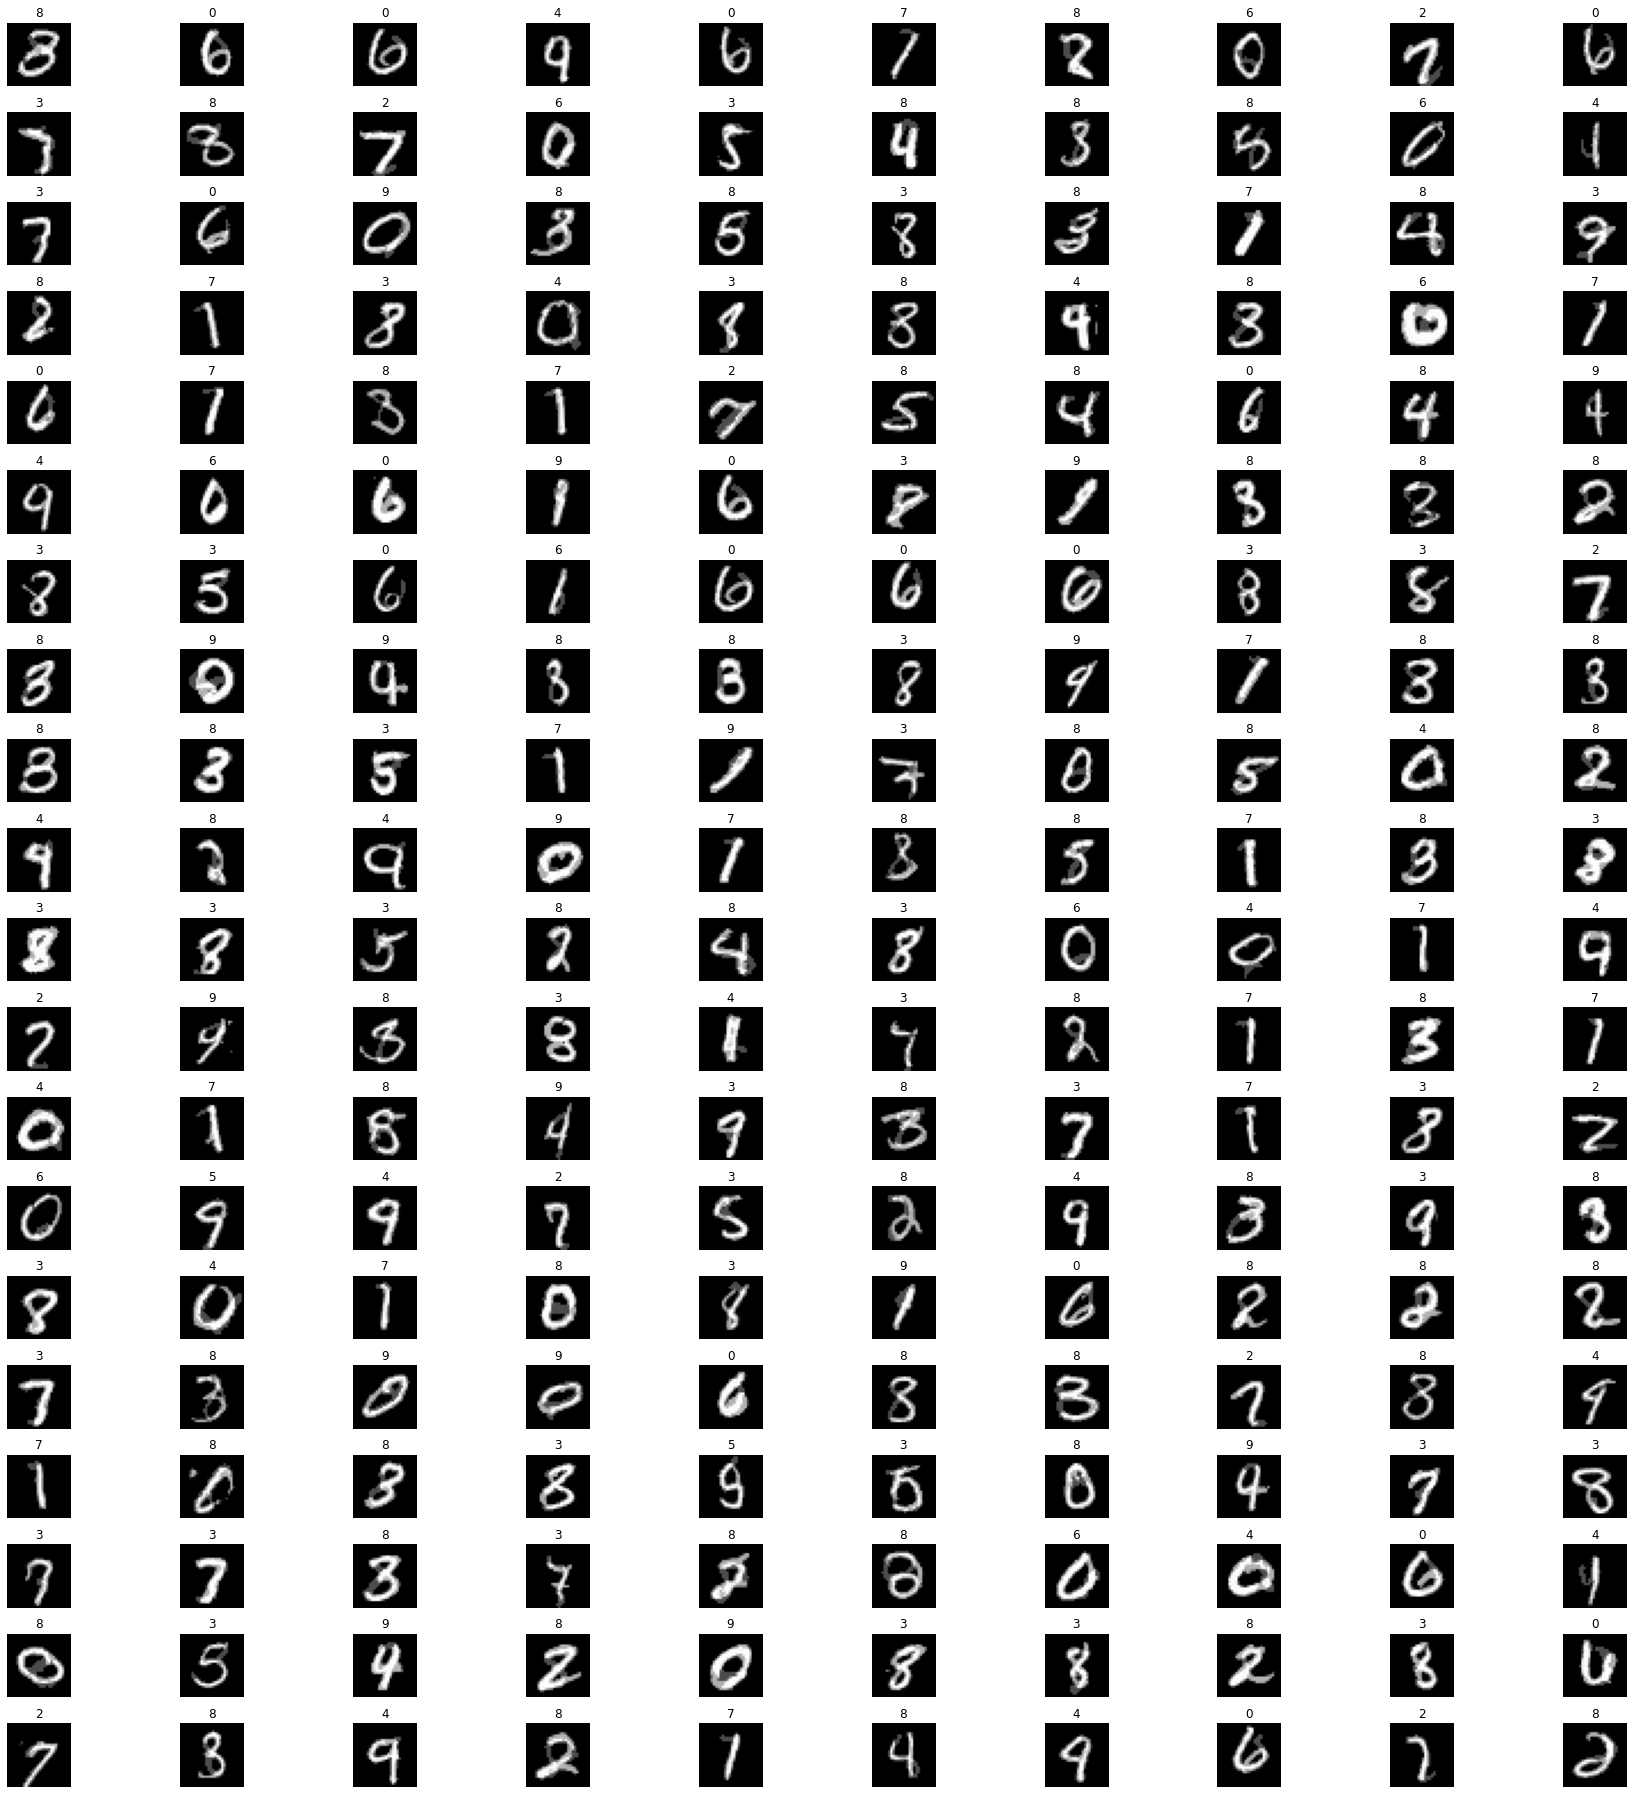

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
all_nns=np.load("all_nns.npy")
all_y_nns=np.load("all_y_nns.npy")
all_grids_nns=np.load("all_grids_nns.npy")
test_xs=np.load("X_test_200.npy")
idxs = np.load("npy/random_indices200.npy")
assert len(idxs) == 200

test_ys = Y_test[idxs]
# fig, ax = plt.subplots(max(len(all_nns), 2), len(all_nns[0])+2, 
#                        figsize=(10*2, len(all_nns)*1.5))
# [a.axis('off') for a in np.asarray(ax).reshape(-1)]

# manually chosen target classes for each source class
targets = {
    0: [4, 6, 8, 9],
    1: [4, 6, 7, 9],
    2: [8],
    3: [8],
    4: [8, 9],
    5: [3, 8],
    6: [0],
    7: [2, 3],
    8: [3],
    9: [3, 4, 5]
}

best_y_advs = []
best_targets = []
best_advs = []

for i in range(len(all_nns)):
    x = test_xs[i]
    y = test_ys[i]
    # ax[i, 0].imshow(255-x, cmap='gray', vmin=0, vmax=255)
    
    best_x_adv = None
    best_nn_adv = None
    amount_removed = []
    amount_added = []
    rot = []
    best_y = None
    min_removed = np.inf
    for j in range(len(all_nns[i])):
        nn_adv = all_nns[i][j]
        y_nn = all_y_nns[i][j]
        x_adv = linf_attack(x, nn_adv, eps=0.3)
        # ax[i, 1+y_nn].imshow(255-x_adv, cmap='gray', vmin=0, vmax=255)
        
        # retain the target that required the least amount of pixels to be "removed"
        curr_rot = np.abs(all_grids_nns[i][j][-1])
        curr_removed = np.sum(np.abs(np.maximum(x/255. - x_adv/255., 0)))
        
        if y_nn in targets[y] and curr_removed < min_removed:
            min_removed = curr_removed
            best_y = y_nn
            best_x_adv = x_adv
            best_nn_adv = (nn_adv, y_nn)
                
    best_targets.append(best_nn_adv)
    best_advs.append(best_x_adv)
    best_y_advs.append(best_y)
# print("BEST Y: ", np.shape(best_advs))
# print("BEST X: ",np.shape(best_y_advs))

_, ax = plt.subplots(20, 10, figsize=(25, 25))
j=0
for i in range(200):
    x=best_advs[i]
    if i>0:
        if i%10==0:
            j+=1
    # print("ax[{},{}]".format(j, i%10))
    
    ax[j, i%10].imshow(x,cmap='gray')
    ax[j, i%10].axis('off')
    ax[j,i%10].set_title(best_y_advs[i])
# for i in range(200):
#     temp = np.ones((32, 32, 3), dtype=np.float32)
#     x=best_advs[i]
#     # x=x[:,:,0]
#     # temp[2:-2, 2:-2, 0] = x
#     # temp[2:-2, 2:-2, 1] = x
#     # temp[2:-2, 2:-2, 2] = x
#     print("ax[{},{}]".format(i//20, i%10))
#     ax[i//20, i%10].imshow(x)
#     ax[i//20, i%10].axis('off')
_.tight_layout(pad=1.0)
plt.show()

np.save("npy/invariance-based_adversarial_examples", best_advs)
np.save("npy/invariance-based_adversarial_examples_labels", best_y_advs)
